## Build GAN using CNN for generating gaussian blur images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batchsize = 100

# pick three categories
classes2keep = [ 'Trouser','Sneaker','Pullover' ]
# classes2keep = [ 'Trouser','Sneaker', 'Sandal'  ] # will show effect of biases in GANs

In [5]:
def get_images(visualize=False):

  # transformations
  transform = T.Compose([
    T.ToTensor(),
    T.Resize(64),
    T.Normalize(.5, .5)
  ])

  # import the data and simultaneously apply the transform
  dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

  # list the categories
  # print(dataset.classes)

  # find the corresponding data indices
  images2use = torch.Tensor()
  for i in range(len(classes2keep)):
    classidx = dataset.classes.index(classes2keep[i])
    images2use = torch.cat( (images2use, torch.where(dataset.targets == classidx)[0]), 0).type(torch.long)
    print(f'Added class {classes2keep[i]} (index {classidx})')

  # transform to dataloaders
  sampler     = torch.utils.data.sampler.SubsetRandomSampler(images2use)
  data_loader = DataLoader(dataset, sampler=sampler, batch_size=batchsize, drop_last=True)


  if visualize:
    X,y = next(iter(data_loader))
    fig,axs = plt.subplots(3, 6, figsize=(10,6))

    for (i,ax) in enumerate(axs.flatten()):
      # extract that image
      pic = torch.squeeze(X.data[i])
      pic = pic/2 + .5 # undo normalization

      # and its label
      label = dataset.classes[y[i]]

      # and show!
      ax.imshow(pic, cmap='gray')
      ax.text(14, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
      ax.axis('off')

    plt.tight_layout()
    plt.show()

  return data_loader

100%|██████████| 26421880/26421880 [00:01<00:00, 15859702.08it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 249481.84it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5039376.01it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22191446.03it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


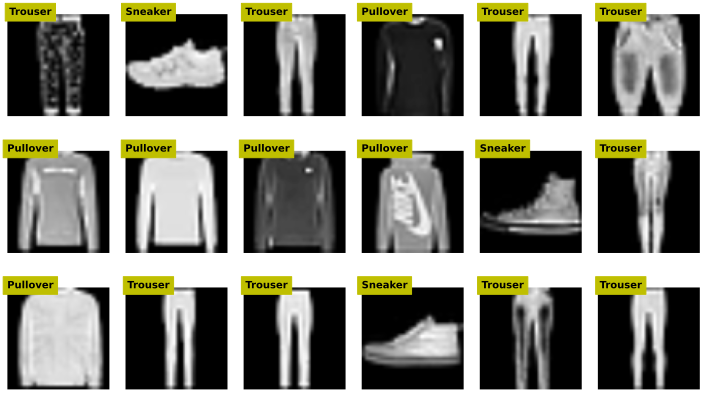

In [6]:
_ = get_images(True)

## Describe the `DiscriminatorNet` model and `GeneratorNet` model

The architecture and metaparameter is inspired from [this source](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

In [7]:
class DiscriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  1,  64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64, 128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,   1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    # print(x.shape)
    x = F.leaky_relu( self.conv1(x) ,.2)
    # print(x.shape)
    x = F.leaky_relu( self.conv2(x) ,.2)
    # print(x.shape)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    # print(x.shape)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    # print(x.shape)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)

In [8]:
class GeneratorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128,  64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,    1, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    # print(x.shape)
    x = F.relu( self.bn1(self.conv1(x)) )
    # print(x.shape)
    x = F.relu( self.bn2(self.conv2(x)) )
    # print(x.shape)
    x = F.relu( self.bn3(self.conv3(x)) )
    # print(x.shape)
    x = F.relu( self.bn4(self.conv4(x)) )
    # print(x.shape)
    x = torch.tanh( self.conv5(x) )
    # print(x.shape)
    return x

In [9]:
# test run models
dnet = DiscriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

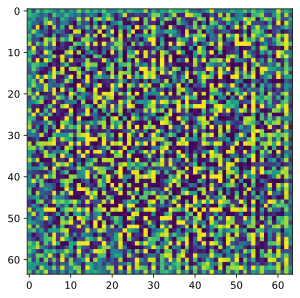

In [10]:
gnet = GeneratorNet()
y = gnet(torch.randn(10,100,1,1))
# print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy())

## Model training function

In [15]:
def train_model():

  data_loader = get_images()

  dnet = DiscriminatorNet().to(device)
  gnet = GeneratorNet().to(device)

  lossfun = nn.BCELoss()

  d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))
  g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))

  # training parameters and initializations
  num_epochs = int( 2500 / len(data_loader) )
  losses     = []
  disDecs    = []

  for epochi in range(num_epochs):

    for data, _ in data_loader:

      # send data to GPU
      data = data.to(device)

      # create labels for real and fake images
      real_labels = torch.ones(batchsize, 1).to(device)
      fake_labels = torch.zeros(batchsize, 1).to(device)


      ### ---------------- Train the discriminator ---------------- ###

      # forward pass and loss for REAL pictures
      pred_real   = dnet(data)                      # output of discriminator
      d_loss_real = lossfun(pred_real, real_labels) # all labels are 1

      # forward pass and loss for FAKE pictures
      fake_data   = torch.randn(batchsize, 100, 1, 1).to(device) # random numbers to seed the generator
      fake_images = gnet(fake_data)                              # output of generator
      pred_fake   = dnet(fake_images)                            # pass through discriminator
      d_loss_fake = lossfun(pred_fake, fake_labels)              # all labels are 0

      # collect loss (using combined losses)
      d_loss = d_loss_real + d_loss_fake

      # backprop
      d_optimizer.zero_grad()
      d_loss.backward()
      d_optimizer.step()


      ### ---------------- Train the generator ---------------- ###

      # create fake images and compute loss
      fake_images = gnet( torch.randn(batchsize, 100, 1, 1).to(device) )
      pred_fake   = dnet(fake_images)

      # compute loss
      g_loss = lossfun(pred_fake, real_labels)

      # backprop
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

      # collect losses and discriminator decisions
      losses.append([d_loss.cpu().item(), g_loss.cpu().item()])

      d1 = torch.mean((pred_real > .5).float()).cpu().detach()
      d2 = torch.mean((pred_fake > .5).float()).cpu().detach()
      disDecs.append([d1, d2])

    # end batch loop

    # print out a status message
    msg = f'Finished epoch {epochi+1} / {num_epochs}'
    sys.stdout.write('\r' + msg)

  # end epoch loop

  # convert performance from list to numpy array
  losses  = np.array(losses)
  disDecs = np.array(disDecs)

  return losses, disDecs, dnet, gnet

In [16]:
# create a 1D smoothing filter
def smooth(x, k=15):
  return np.convolve(x, np.ones(k) / k, mode='same')

In [17]:
losses, disDecs, _, gnet = train_model()

Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)
Finished epoch 13 / 13

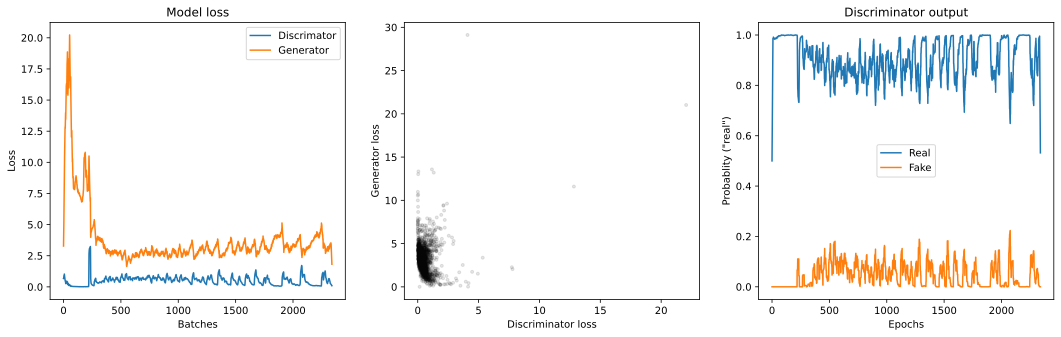

In [18]:
_, ax = plt.subplots(1, 3, figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500, 900])
# ax[0].set_ylim([0, 2.5])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real', 'Fake'])

plt.show()

## Genreate some images with `GeneratorNet`

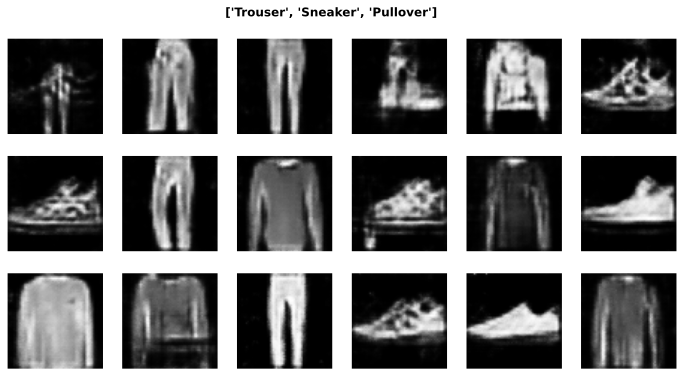

In [20]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize, 100, 1, 1).to(device) ).cpu()

# and visualize...
_, axs = plt.subplots(3, 6, figsize=(12,6))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(), cmap='gray')
  ax.axis('off')

plt.suptitle(classes2keep, y=.95, fontweight='bold')
plt.show()